In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [122]:
from typing import Tuple

import pandas as pd

from plotting import plot_ts
from load_dataset import Dataset
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

In [15]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

from metrics import mean_absolute_percentage_error as mape
from metrics import mase

In [16]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_indx = int(len(ts)*ratio)
    ts_train, ts_test = ts[:split_indx], ts[split_indx:]
    return ts_train, ts_test

In [18]:
def calculate_metrics(test, in_sample, out_sample):
        metrics={   'mse':{'in':0, 'out':0},
                    'mae':{'in':0, 'out':0},
                    'r2_score':{'in':0, 'out':0},
                    'mape':{'in':0, 'out':0},
                    'mase':{'in':0, 'out':0}}

        metrics['mse']['in'] = MSE(test, in_sample)
        metrics['mse']['out'] = MSE(test, out_of_sample)
        metrics['mae']['in'] = MAE(test, in_sample)
        metrics['mae']['out'] = MAE(test, out_of_sample)
        metrics['r2_score']['in'] = r2_score(test, in_sample)
        metrics['r2_score']['out'] = r2_score(test, out_of_sample)
        metrics['mape']['in'] = mape(test, in_sample) 
        metrics['mape']['out'] = mape(test, out_of_sample)
        metrics['mase']['in'] = mase(in_sample, test)
        metrics['mase']['out'] = mase(out_of_sample, test)

        return metrics

In [339]:
def extract_trend(ts: pd.Series):
    """
    Извлекает линейный тренд из временного ряда
    """
    # <ваш код здесь>
    k, b = np.polyfit(range(len(ts)), ts.values, 1)
    trend = pd.Series(k * np.array(range(len(ts))) + b, index=ts.index)
    return trend, k, b

In [19]:
def test_adfuler(data):
    test = adfuller(data.dropna())
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [198]:
ds = Dataset('../data/dataset/')
ts = ds['dow_jones_0.csv']

In [199]:
#заполняем пропуски в датах
data_per_day = pd.Series({'value':np.NaN}, index=pd.date_range(
                            start=ts[:1].index.values[0],
                            end=ts[-1:].index.values[0],
                            freq='D'))
ts = ts.groupby(ts.index).first() #убираем дубликаты
ts = data_per_day.combine_first(ts) #соединяем 
ts.index = pd.DatetimeIndex(ts.index).to_period('D')
ts.fillna(method='pad', inplace=True) #заполняем NaN предыдущими значениями
ts.index=ts.index.to_timestamp()

2 балла) Используя подход box-jenkins постройте модель ARIMA 
(statsmodels.tsa.arima_model) для временного ряда dow_jones_0. 
Сделайте прогноз на 30 точек вперед. Интерпретируйте
полученный результат. 

1.Убрать гетероскедастичность при помощи логарифмирования.

2.Продифференцировать разными способами и узнать нужный порядок дифференцирования d, D, анализируя получившийся ряд при помощи графика acf_plot и теста дикки-фуллера.

3.Оценить параметры (q, Q), (p, P) по графикам acf, pacf продифференцированного ряда.

4.Обучить модель SARIMA и попробовать сделать предсказания исходного ряда.

5.Критерий хорошей модели (в идеале) - стационарные остатки.

<AxesSubplot:>

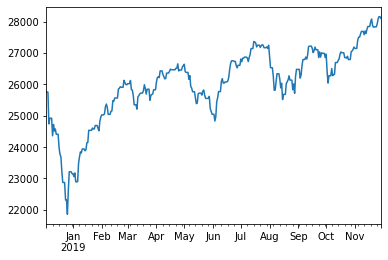

In [200]:
ts.plot()

In [201]:
ts_log = np.log(ts)

In [202]:
test_adfuler(ts_log)

adf:  -0.9154498290851543
p-value:  0.7828419984756327
Critical values:  {'1%': -3.4485948978753314, '5%': -2.86957971128312, '10%': -2.571053050314224}
есть единичные корни, ряд не стационарен


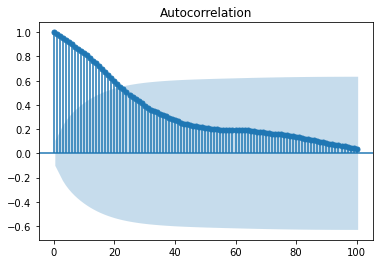

In [203]:
tsaplots.plot_acf(ts_log, lags=100);

## сезонности нет

adf:  -18.392251819033298
p-value:  2.1997030827870432e-30
Critical values:  {'1%': -3.448645946352023, '5%': -2.869602139060357, '10%': -2.5710650077160495}
единичных корней нет, ряд стационарен


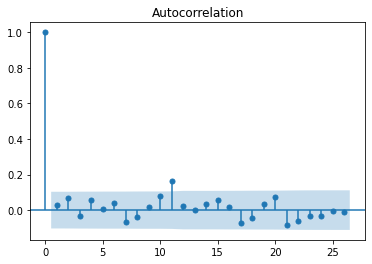

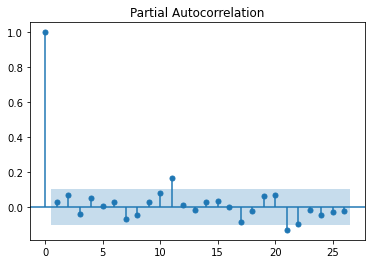

In [204]:
#дифференцируем, для получения стационарного ряда
ts_log_diff = ts_log.diff().dropna()
test_adfuler(ts_log_diff)
tsaplots.plot_acf(ts_log_diff);
tsaplots.plot_pacf(ts_log_diff);

## ряд стационарен, сезонности нет
d=1, D=0, p,P,q,Q=0

In [364]:
ts_train, ts_test = train_test_split(ts_log)
pdq = (0, 1, 0)

In [365]:
model = ARIMA(ts_train, order=pdq)

In [366]:
res = model.fit()

In [367]:
preds=res.forecast(30)

In [368]:
plot_ts(ts_test[:30], preds, legends=['ts_test', 'preds']);

Loading BokehJS ...

## Вывод:
### У ряда нет сезонности, Arima не может прогнозировать ряды со случайным блужданием. Прогноз пострился по медиане.